In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
from scipy.special import hankel1
import matplotlib.pyplot as plt

env: OMP_NUM_THREADS=1


In [2]:
omega = 750
c = 340
k = omega / c
a0 = b0 = 2.0
a1 = b1 = 2.25
x0 = np.array([0.5, 0])

In [3]:
def plot_mesh(m):
    fig, axes = plt.subplots()
    interior_kw = {"linewidths": 0.2}
    fd.triplot(m, axes=axes, interior_kw=interior_kw)
    axes.set_aspect("equal")
    axes.legend()

dof = 127360


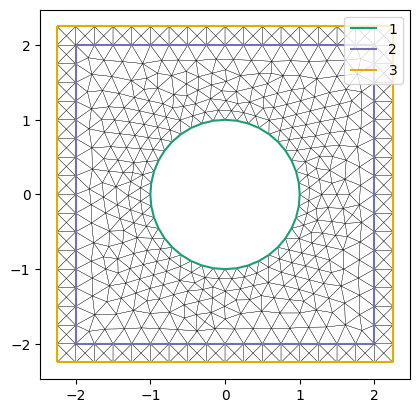

In [4]:
mesh = fd.Mesh("mesh_triangle.msh")
plot_mesh(mesh)

mesh = fd.MeshHierarchy(mesh, 4)[-1]
V = fd.FunctionSpace(mesh, "CG", 1)
print("dof =", V.dof_count)
W = V * V

p_re, p_im = fd.TrialFunctions(W)
q_re, q_im = fd.TestFunctions(W)

s = fd.Function(W)
s_re, s_im = s.split()
exact = fd.Function(W)
exact_re, exact_im = exact.split()

g_re = fd.Function(V)
g_im = fd.Function(V)
c1_re = fd.Function(V)
c1_im = fd.Function(V)
c2_re = fd.Function(V)
c2_im = fd.Function(V)
c3_re = fd.Function(V)
c3_im = fd.Function(V)

X_space = fd.VectorFunctionSpace(V.ufl_domain(), V.ufl_element())
X = fd.interpolate(mesh.coordinates, X_space).dat.data_ro

In [5]:
def split(v):
    return v.real, v.imag

def prod2(x, y):
    x_re, x_im = x
    y_re, y_im = y
    res_re = x_re * y_re - x_im * y_im
    res_im = x_re * y_im + x_im * y_re
    return res_re + res_im

def prod3(x, y, z):
    x_re, x_im = x
    y_re, y_im = y
    z_re, z_im = z
    res_re = x_re * y_re * z_re - x_re * y_im * z_im - x_im * y_re * z_im - x_im * y_im * z_re
    res_im = x_re * y_re * z_im + x_re * y_im * z_re + x_im * y_re * z_re - x_im * y_im * z_im
    return res_re + res_im

In [6]:
dist = np.linalg.norm(X - x0, axis=1)

exact_data = 1j / 4 * hankel1(0, k * dist)
exact_re.dat.data[:], exact_im.dat.data[:] = split(exact_data)

g_data = -1j / 4 * hankel1(1, k * dist) \
         * k / dist * np.einsum("ij,ij->i", X - x0, -X)
g_re.dat.data[:], g_im.dat.data[:] = split(g_data)

In [7]:
np.seterr(all="ignore")
n = X.shape[0]

sigma_x = np.ones(n)
idx = np.where(np.abs(X[:, 0]) > a0 - 1e-8)
sigma_x[idx] = c / (a1 - np.abs(X[idx, 0]))
sigma_x = np.nan_to_num(sigma_x, posinf=1e20)

sigma_y = np.ones(n)
idx = np.where(np.abs(X[:, 1]) > b0 - 1e-8)
sigma_y[idx] = c / (b1 - np.abs(X[idx, 1]))
sigma_y = np.nan_to_num(sigma_y, posinf=1e20)

gamma_x = 1 + 1j / omega * sigma_x
gamma_y = 1 + 1j / omega * sigma_y

c1_re.dat.data[:], c1_im.dat.data[:] = split(gamma_y / gamma_x)
c2_re.dat.data[:], c2_im.dat.data[:] = split(gamma_x / gamma_y)
c3_re.dat.data[:], c3_im.dat.data[:] = split(gamma_x * gamma_y)

In [8]:
p = (p_re, p_im)
px = (p_re.dx(0), p_im.dx(0))
py = (p_re.dx(1), p_im.dx(1))
q = (q_re, q_im)
qx = (q_re.dx(0), q_im.dx(0))
qy = (q_re.dx(1), q_im.dx(1))
c1 = (c1_re, c1_im)
c2 = (c2_re, c2_im)
c3 = (c3_re, c3_im)

a = (prod2(px, qx) + prod2(py, qy) - k**2 * prod2(p, q)) * fd.dx(1) \
    + (prod3(c1, px, qx) + prod3(c2, py, qy) - k**2 * prod3(c3, p, q)) * fd.dx(2)
L = (g_re * q_re - g_im * q_im + g_re * q_im + g_im * q_re) * fd.ds(1)
# L = fd.Constant(0) * (q_re + q_im) * fd.dx

bcs = [fd.DirichletBC(W.sub(0), 0., 3), fd.DirichletBC(W.sub(1), 0., 3)]
# bcs = [fd.DirichletBC(W.sub(0), exact_re, 1), fd.DirichletBC(W.sub(1), exact_im, 1),
#        fd.DirichletBC(W.sub(0), 0., 3), fd.DirichletBC(W.sub(1), 0., 3)]
fd.solve(a == L, s, bcs=bcs)

In [9]:
def plot_field(u_re, u_im):
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)

    plot1 = fd.tripcolor(u_re, axes=ax1)
    ax1.set_aspect("equal")
    ax1.set_title("Real part")
    ax1.set_xlim(-a1, a1)
    ax1.set_ylim(-b1, b1)
    ax1.add_patch(
        plt.Rectangle((-a0, -b0), 2*a0, 2*b0, color='w', fill=False))
    fig.colorbar(plot1, shrink=0.5, ax=ax1)
    
    plot2 = fd.tripcolor(u_im, axes=ax2)
    ax2.set_aspect("equal")
    ax2.set_title("Imaginary part")
    ax2.set_xlim(-a1, a1)
    ax2.set_ylim(-b1, b1)
    ax2.add_patch(
        plt.Rectangle((-a0, -b0), 2*a0, 2*b0, color='w', fill=False))
    fig.colorbar(plot2, shrink=0.5, ax=ax2)

Exact solution:


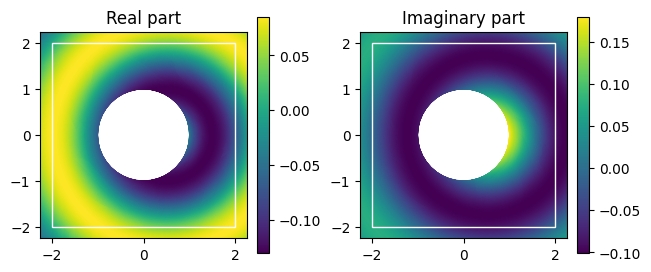

In [10]:
print("Exact solution:")
plot_field(exact_re, exact_im)

Numerical solution:


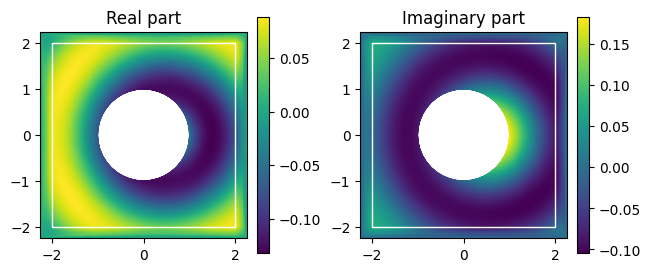

In [11]:
print("Numerical solution:")
plot_field(s_re, s_im)

In [12]:
def compute_error(u, uh, relative=True):
    v = u - uh
    err = fd.assemble(fd.inner(v, v) * fd.dx(1))**0.5
    if relative:
        err /= fd.assemble(fd.inner(u, u) * fd.dx(1))**0.5
    return err

In [13]:
rel_err = compute_error(exact, s)
print(f"Relative error is {rel_err:.2%}")

Relative error is 2.99%
